In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

def add(a, b):
   Subtraction = a-b
   return Subtraction

 add(a, b) print(addition)

-178


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
datapath = Path("/content/gdrive/MyDrive/DRL/GNSS/")

## Background

Every satellite in space continuously broadcasts its current position coordinate information to the world through satellite signals. Any GNSS receiver can receive and read this information through an antenna.

When the satellite sends position information, it also attaches the timestamp when the data was sent. After the GNSS receiver receives the data, it subtracts the time on the timestamp from the current time, which is the time taken for the data transmission. And the approximate distance between the satellite and the GPS receiver can be calculated by data transmission time multiplied by the transmission speed, which is the `rawPrM` in `_derived` table.

The most difficult problem in GPS positioning is error. There are many reasons for positioning errors, such as the ionosphere, the receiving device, and the blocking and multipath effects. Inorder to get a more accurate the approximate distance between the satellite and the GPS receiver with as less error as possible, which can be computed as: `correctedPrM = rawPrM + satClkBiasM - isrbM - ionoDelayM - tropoDelayM`

<img src='https://www.researchgate.net/publication/324989880/figure/fig1/AS:623672356253699@1525706485241/Global-Navigation-Satellite-System-GNSS-spoofing-attack-illustration.png' width=400/>

Normally these values are need to be calculated carefully from GNSSLog file by lots of domain knowledge. Thanks to the dataset provider, we can directly use the intermediate calculated value from derived files to built the initial version of the model.

### Basic Utils Functions

In [ ]:
def ecef2lla(x, y, z):
  # x, y and z are scalars or vectors in meters
  x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
  y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
  z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

  a=6378137
  a_sq=a**2
  e = 8.181919084261345e-2
  e_sq = 6.69437999014e-3

  f = 1/298.257223563
  b = a*(1-f)

  # calculations:
  r = np.sqrt(x**2 + y**2)
  ep_sq  = (a**2-b**2)/b**2
  ee = (a**2-b**2)
  f = (54*b**2)*(z**2)
  g = r**2 + (1 - e_sq)*(z**2) - e_sq*ee*2
  c = (e_sq**2)*f*r**2/(g**3)
  s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3.)
  p = f/(3.*(g**2)*(s + (1./s) + 1)**2)
  q = np.sqrt(1 + 2*p*e_sq**2)
  r_0 = -(p*e_sq*r)/(1+q) + np.sqrt(0.5*(a**2)*(1+(1./q)) - p*(z**2)*(1-e_sq)/(q*(1+q)) - 0.5*p*(r**2))
  u = np.sqrt((r - e_sq*r_0)**2 + z**2)
  v = np.sqrt((r - e_sq*r_0)**2 + (1 - e_sq)*z**2)
  z_0 = (b**2)*z/(a*v)
  h = u*(1 - b**2/(a*v))
  phi = np.arctan((z + ep_sq*z_0)/r)
  lambd = np.arctan2(y, x)

  return phi*180/np.pi, lambd*180/np.pi, h

### Load Data

In [ ]:
date_folder = os.listdir('/content/gdrive/MyDrive/DRL/GNSS/train')
df_baseline = pd.read_csv('/content/gdrive/MyDrive/DRL/GNSS/baseline_locations_train.csv')
df_baseline_test = pd.read_csv('/content/gdrive/MyDrive/DRL/GNSS/baseline_locations_test.csv')

# df_sample_trail_gt = pd.DataFrame()
# df_sample_trail = pd.DataFrame()
# for i in date_folder:
#   if 'Pixel4' in os.listdir(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}'):
#     df_sample_trail_gt_1 = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}/Pixel4/ground_truth.csv')
#     df_sample_trail_1 = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}/Pixel4/Pixel4_derived.csv')
#   elif 'Pixel5' in os.listdir(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}'):
#     df_sample_trail_gt_1 = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}/Pixel5/ground_truth.csv')
#     df_sample_trail_1 = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}/Pixel5/Pixel5_derived.csv')
#   elif 'Mi8' in os.listdir(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}'):
#     df_sample_trail_gt_1 = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}/Mi8/ground_truth.csv')
#     df_sample_trail_1 = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}/Mi8/Mi8_derived.csv')
#   else:
#     df_sample_trail_gt_1 = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}/Pixel4XL/ground_truth.csv')
#     df_sample_trail_1 = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/{i}/Pixel4XL/Pixel4XL_derived.csv')

#   df_sample_trail_gt = pd.concat([df_sample_trail_gt,df_sample_trail_gt_1])
#   df_sample_trail = pd.concat([df_sample_trail,df_sample_trail_1])

df_sample_trail_gt = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv')
df_sample_trail = pd.read_csv(f'/content/gdrive/MyDrive/DRL/GNSS/train/2020-05-14-US-MTV-1/Pixel4/Pixel4_derived.csv')

#df_baseline = pd.read_csv("baseline_locations_train.csv")
#df_sample_trail_gt = pd.read_csv("ground_truth.csv")
#df_sample_trail = pd.read_csv("Pixel4_derived.csv")
df_sample_trail["correctedPrM"] = df_sample_trail["rawPrM"] + df_sample_trail["satClkBiasM"] - df_sample_trail["isrbM"] - df_sample_trail["ionoDelayM"] - df_sample_trail["tropoDelayM"]

## Simple Least Square Solution

An intuitive solution to solve this problem is utilizing the basic geometry information to infer the GNSS receiver location. Since we have multiple satellite, we can optimize the location to achieve the minimum projection error among all satellite based by least square.

To be more specific,

$r_u^k = ||x^k_{sat} - x_u||$

where,

$r_u^k$: the actually distance between user device (GNSS Receiver) to Satellite;

$x^k_{sat}$: the actually position of Satellite;

$x_u$: the actually position of user device (GNSS Receiver).

$ Pr_u^k = r_u^k + b_u + \sigma^k $

where,

$Pr_u^k$: the corrected pseudorange (i.e. a closer approximation to the geometric range from the phone to the satellite) can be computed as: $correctedPrM = rawPrM + satClkBiasM - isrbM - ionoDelayM - tropoDelayM;$

$b_u$: the user clock bias in meters equivalent, which $b_u = clock\_bias_u * LIGHTSPEED;$

$\sigma^k$: the actually position of user device (GNSS Receiver).

Our aim is to minimize the measured and the estimated pseudorange for each satellite:

$$\delta Pr_u^k = Pr_u^k - (r_u^k + b_u) = Pr_u^k - (||x^k_{sat} - x_u|| + b_u)$$

which is our target function in least square solver.

 Which can be deducted to based equation (5)
$$\delta Pr_u^k = - \frac{x^k_{sat} - x_u}{||x^k_{sat} - x_u||} \delta x_u^k + \delta b_u + \sigma^k = - \hat{x}_u^k \delta x_u^k + \delta b_u + \sigma^k$$ --

Let's try it with 1 single epoch.

In [ ]:
epoch_time = 1273529464442
df_sample_epoch = df_sample_trail[df_sample_trail.millisSinceGpsEpoch == epoch_time]
df_sample_epoch_gt = df_sample_trail_gt[df_sample_trail_gt.millisSinceGpsEpoch == epoch_time]
df_sample_epoch_baseline = df_baseline[(df_baseline.collectionName == "2020-05-14-US-MTV-1") & (df_baseline.phoneName == "Pixel4") & (df_baseline.millisSinceGpsEpoch == epoch_time)]

sat_pos = df_sample_epoch[["xSatPosM","ySatPosM","zSatPosM"]].to_numpy()
pseudoranges = np.squeeze(df_sample_epoch[["correctedPrM"]].to_numpy())

### self implement simple least square



In [ ]:
def least_squares(sat_pos, pseudoranges, weights=1, x_hat=np.array([0, 0, 0, 0])):
  """
  Args:
    sat_pos: The satellite position (meters) in an ECEF coordinate frame
    pseudoranges: The corrected pseudorange (i.e. a closer approximation to the geometric range from the phone to the satellite)
    x_hat: the phone's initial/previous estimated position (x, y, z, b) and
           b represent the user clock bias in units of distance = clock bias (t) * light speed (c)

  Returns:
    x_hat: the phone's estimated position
    norm_dp:
  """
  dx = np.Inf*np.ones(3)
  G = np.ones((pseudoranges.size, 4))
  iterations = 0

  if isinstance(weights, np.ndarray):
    weights = np.diag(weights)
  else:
    weights = weights*np.eye(pseudoranges.size)

  while np.linalg.norm(dx) > 1e-3:
    norms = np.linalg.norm(sat_pos - x_hat[:3], axis=1)
    dp = pseudoranges - norms - x_hat[3]
    G[:, 0:3] = -(sat_pos - x_hat[:3])/norms[:, None]
    # G_T = np.transpose(G) q
    # dx = np.linalg.inv(G_T@G) @ G_T @ dp
    dx = np.linalg.pinv(weights@G) @ weights @ dp
    x_hat = x_hat + dx
    iterations += 1
  return x_hat, np.linalg.norm(dp)

In [ ]:
x, dp = least_squares(sat_pos, pseudoranges)

print("Ground truth:", df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation (Baseline):", df_sample_epoch_baseline[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Simple Least Square Estimation:", *ecef2lla(*x[:3]))
# print("Simple Least Square Estimation:", (x[:3]))
# print(b/LIGHTSPEED)
# print(dp)

Ground truth: [[  37.42357595 -122.09413204   33.21      ]]
Weighted Least Square Estimation (Baseline): [[  37.4235777 -122.094101   -33.29     ]]
Simple Least Square Estimation: [[37.42361372]] [[-122.0936959]] [[-26.18615617]]


### scipy optimize version



In [ ]:
import scipy.optimize as opt

def calc_pos_fix(sat_pos, pr, weights=1, x0=[0, 0, 0, 0]):
  '''
  Calculates gps fix with WLS optimizer
  returns:
  0 -> list with positions
  1 -> pseudorange errs
  '''
  n = len(pr)
  if n < 3:
      return x0, []

  Fx_pos = pr_residual(sat_pos, pr, weights=weights)
  opt_pos = opt.least_squares(Fx_pos, x0).x
  return opt_pos, Fx_pos(opt_pos, weights=1)


def pr_residual(sat_pos, pr, weights=1):
  # solve for pos
  def Fx_pos(x_hat, weights=weights):
    rows = weights * (np.linalg.norm(sat_pos - x_hat[:3], axis=1) + x_hat[3] - pr)
    return rows
  return Fx_pos

In [ ]:
x, dp = calc_pos_fix(sat_pos, pseudoranges)

print("Ground truth:", df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation (Baseline):", df_sample_epoch_baseline[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Simple Least Square Estimation:", *ecef2lla(*x[:3]))
# print(x[3]/LIGHTSPEED)
# print(dp)

Ground truth: [[  37.42357595 -122.09413204   33.21      ]]
Weighted Least Square Estimation (Baseline): [[  37.4235777 -122.094101   -33.29     ]]
Simple Least Square Estimation: [[37.42361372]] [[-122.0936959]] [[-26.18615818]]


## Weighted Least Square Solution

In [ ]:
pseudoranges_sigma = np.squeeze(df_sample_epoch[["rawPrUncM"]].to_numpy())

x, dp = least_squares(sat_pos, pseudoranges, 1/pseudoranges_sigma)

print("Ground truth:", df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation (Baseline):", df_sample_epoch_baseline[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation:", *ecef2lla(*x[:3]))

Ground truth: [[  37.42357595 -122.09413204   33.21      ]]
Weighted Least Square Estimation (Baseline): [[  37.4235777 -122.094101   -33.29     ]]
Weighted Least Square Estimation: [[37.42357917]] [[-122.09375829]] [[-35.25074978]]


In [ ]:
# Assuming you have already defined the functions and performed the WLS estimation
# Also, df_sample_trails and df_sample_trails_gt are your initial DataFrames

# Initialize an empty list to store results
wls_results = []

# Iterate over unique epoch times
for epoch_time in tqdm(df_sample_trail["millisSinceGpsEpoch"].unique(), desc="Processing WLS for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_sample_trail[df_sample_trail["millisSinceGpsEpoch"] == epoch_time]
    df_sample_epoch_gt = df_sample_trail_gt[df_sample_trail_gt["millisSinceGpsEpoch"] == epoch_time]

    # Perform WLS estimation
    sat_pos = df_sample_epoch[["xSatPosM", "ySatPosM", "zSatPosM"]].to_numpy()
    pseudoranges = np.squeeze(df_sample_epoch[["correctedPrM"]].to_numpy())
    x, _ = calc_pos_fix(sat_pos, pseudoranges)

    # Extract relevant information (lat, lng, height) from the WLS result
    lat, lng, height = ecef2lla(*x[:3])

    # Append the results to the list
    wls_results.append({
        "collectionName": df_sample_epoch["collectionName"].values[0],
        "phoneName": df_sample_epoch["phoneName"].values[0],
        "millisSinceGpsEpoch": epoch_time,
        "latDeg": lat,
        "lngDeg": lng,
        "heightAboveWgs84EllipsoidM": height
    })

# Create a DataFrame from the list of results
df_wls_output = pd.DataFrame(wls_results)

# Save the DataFrame to a CSV file
df_wls_output.to_csv("wls_output.csv", index=False)


Processing WLS for each epoch:   0%|          | 0/1739 [00:00<?, ?it/s]

In [ ]:
print(df_wls_output.dtypes)

collectionName                object
phoneName                     object
millisSinceGpsEpoch            int64
latDeg                        object
lngDeg                        object
heightAboveWgs84EllipsoidM    object
dtype: object


In [ ]:
len(df_sample_trail.millisSinceGpsEpoch.unique())

1739

In [ ]:
df_wls_output

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM
0,2020-05-14-US-MTV-1,Pixel4,1273529464442,[[37.42361371686234]],[[-122.09369590126298]],[[-26.18615799018186]]
1,2020-05-14-US-MTV-1,Pixel4,1273529465442,[[37.42357014192776]],[[-122.09371182234247]],[[-28.807835879816857]]
2,2020-05-14-US-MTV-1,Pixel4,1273529466442,[[37.42359878848782]],[[-122.09378542747734]],[[-30.286553878799182]]
3,2020-05-14-US-MTV-1,Pixel4,1273529467442,[[37.42357241889501]],[[-122.09378123894098]],[[-19.202859730644562]]
4,2020-05-14-US-MTV-1,Pixel4,1273529468442,[[37.423569285705995]],[[-122.09378934302913]],[[-30.726322743404626]]
...,...,...,...,...,...,...
1734,2020-05-14-US-MTV-1,Pixel4,1273531198442,[[37.64580948493906]],[[-122.40529487923173]],[[-23.028509074884553]]
1735,2020-05-14-US-MTV-1,Pixel4,1273531199442,[[37.645792597793026]],[[-122.40530193889808]],[[-28.042619187194727]]
1736,2020-05-14-US-MTV-1,Pixel4,1273531200442,[[37.64578455390121]],[[-122.40528859460647]],[[-32.02928173035615]]
1737,2020-05-14-US-MTV-1,Pixel4,1273531201442,[[37.6457835755084]],[[-122.40526745488549]],[[-28.30128201239843]]


In [ ]:
len(df_sample_trail_gt.millisSinceGpsEpoch.unique())

1740

In [ ]:
df_sample_trail_gt

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423576,-122.094132,33.21,551.44,1.1,0.0,0.0,12.7
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423576,-122.094132,33.21,552.44,1.1,0.0,0.0,12.7
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423576,-122.094132,33.21,553.44,1.1,0.0,0.0,12.7
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423576,-122.094132,33.20,554.44,1.1,0.0,0.0,12.7
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423576,-122.094132,33.20,555.44,1.1,0.0,0.0,12.7
...,...,...,...,...,...,...,...,...,...,...,...
1735,2020-05-14-US-MTV-1,Pixel4,1273531198442,37.645823,-122.405608,33.56,2286.44,0.8,0.0,0.0,161.7
1736,2020-05-14-US-MTV-1,Pixel4,1273531199442,37.645823,-122.405608,33.56,2287.44,0.8,0.0,0.0,161.7
1737,2020-05-14-US-MTV-1,Pixel4,1273531200442,37.645823,-122.405608,33.56,2288.44,0.8,0.0,0.0,161.7
1738,2020-05-14-US-MTV-1,Pixel4,1273531201442,37.645823,-122.405608,33.56,2289.44,0.8,0.0,0.0,161.7


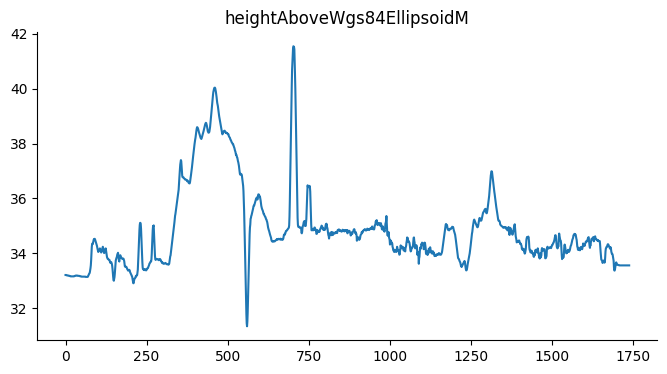

In [ ]:
# @title heightAboveWgs84EllipsoidM

from matplotlib import pyplot as plt
df_sample_trail_gt['heightAboveWgs84EllipsoidM'].plot(kind='line', figsize=(8, 4), title='heightAboveWgs84EllipsoidM')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df_sample_trail_gt_final = pd.DataFrame()
df_wls_output_final = pd.DataFrame()
for i in df_wls_output["millisSinceGpsEpoch"].unique():
  if i in df_sample_trail_gt['millisSinceGpsEpoch'].unique():
    unq_df_sample_trail_gt = df_sample_trail_gt[df_sample_trail_gt['millisSinceGpsEpoch']== i]
    unq_df_wls_output = df_wls_output[df_wls_output['millisSinceGpsEpoch']== i]
    df_sample_trail_gt_final = pd.concat([df_sample_trail_gt_final,unq_df_sample_trail_gt])
    df_wls_output_final = pd.concat([df_wls_output_final,unq_df_wls_output])

# SVR (Support Vector Regression) solution


In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Assuming df_wls_output_final and df_sample_trail_gt_final are the DataFrames containing your data
Xsvr = df_wls_output_final[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
ysvr_lat = df_sample_trail_gt_final["latDeg"]
ysvr_lng = df_sample_trail_gt_final["lngDeg"]
ysvr_height = df_sample_trail_gt_final["heightAboveWgs84EllipsoidM"]

# Initialize a list to store the results for each epoch
svr_results = []
predicted_values = []

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output_final["millisSinceGpsEpoch"].unique(), desc="Training SVR for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output_final[df_wls_output_final["millisSinceGpsEpoch"] == epoch_time]

    # Split the data into training and testing sets
    Xsvr_train, Xsvr_test, ysvr_lat_train, ysvr_lat_test, ysvr_lng_train, ysvr_lng_test, ysvr_height_train, ysvr_height_test = train_test_split(
        Xsvr, ysvr_lat, ysvr_lng, ysvr_height, test_size=0.2, random_state=42
    )

    # Standardize the features
    scaler_Xsvr = StandardScaler()
    Xsvr_train_scaled = scaler_Xsvr.fit_transform(Xsvr_train)
    Xsvr_test_scaled = scaler_Xsvr.transform(Xsvr_test)

    # Standardize the target variables
    scaler_ysvr_lat = StandardScaler()
    ysvr_lat_train_scaled = scaler_ysvr_lat.fit_transform(ysvr_lat_train.values.reshape(-1, 1))
    ysvr_lat_test_scaled = scaler_ysvr_lat.transform(ysvr_lat_test.values.reshape(-1, 1))

    scaler_ysvr_lng = StandardScaler()
    ysvr_lng_train_scaled = scaler_ysvr_lng.fit_transform(ysvr_lng_train.values.reshape(-1, 1))
    ysvr_lng_test_scaled = scaler_ysvr_lng.transform(ysvr_lng_test.values.reshape(-1, 1))

    scaler_ysvr_height = StandardScaler()
    ysvr_height_train_scaled = scaler_ysvr_height.fit_transform(ysvr_height_train.values.reshape(-1, 1))
    ysvr_height_test_scaled = scaler_ysvr_height.transform(ysvr_height_test.values.reshape(-1, 1))

    # SVR model for latitude
    svr_lat = SVR(kernel='linear')
    svr_lat.fit(Xsvr_train_scaled, ysvr_lat_train_scaled.ravel())

    # SVR model for longitude
    svr_lng = SVR(kernel='linear')
    svr_lng.fit(Xsvr_train_scaled, ysvr_lng_train_scaled.ravel())

    # SVR model for height
    svr_height = SVR(kernel='linear')
    svr_height.fit(Xsvr_train_scaled, ysvr_height_train_scaled.ravel())

    # Predictions
    ysvr_lat_pred_scaled = svr_lat.predict(Xsvr_test_scaled)
    ysvr_lng_pred_scaled = svr_lng.predict(Xsvr_test_scaled)
    ysvr_height_pred_scaled = svr_height.predict(Xsvr_test_scaled)

    # Inverse transform to get original scale
    ysvr_lat_pred = scaler_ysvr_lat.inverse_transform(ysvr_lat_pred_scaled.reshape(-1, 1))
    ysvr_lng_pred = scaler_ysvr_lng.inverse_transform(ysvr_lng_pred_scaled.reshape(-1, 1))
    ysvr_height_pred = scaler_ysvr_height.inverse_transform(ysvr_height_pred_scaled.reshape(-1, 1))

    # Collect the true and predicted values for latitude and longitude
    for true_lat, pred_lat, true_lng, pred_lng in zip(ysvr_lat_test, ysvr_lat_pred, ysvr_lng_test, ysvr_lng_pred):
        predicted_values.append({
            "millisSinceGpsEpoch": epoch_time,
            "true_lat": true_lat,
            "pred_lat": pred_lat[0],
            "true_lng": true_lng,
            "pred_lng": pred_lng[0],
        })

# Create a DataFrame from the list of predicted values
df_predicted_values = pd.DataFrame(predicted_values)

# Save the predicted values DataFrame to a CSV file
csv_path5 = '/content/gdrive/MyDrive/DRL/GNSS/svrpredicted_values.csv'
df_predicted_values.to_csv(csv_path5, index=False)

print('Predicted values for latitude and longitude saved to CSV.')


Training SVR for each epoch: 100%|██████████| 1739/1739 [07:18<00:00,  3.96it/s]


Predicted values for latitude and longitude saved to CSV.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming df_wls_output is the DataFrame containing the output of WLS estimation
# Extract features and target variables
# Xsvr = df_wls_output[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
# ysvr_lat = df_sample_trail_gt["latDeg"]
# ysvr_lng = df_sample_trail_gt["lngDeg"]
# ysvr_height = df_sample_trail_gt["heightAboveWgs84EllipsoidM"]



# Initialize a list to store the results for each epoch
svr_results = []
latsvr_score = []
lngsvr_score = []
heightsvr_score = []

Xsvr = df_wls_output_final[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
ysvr_lat = df_sample_trail_gt_final["latDeg"]
ysvr_lng = df_sample_trail_gt_final["lngDeg"]
ysvr_height = df_sample_trail_gt_final["heightAboveWgs84EllipsoidM"]

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output_final["millisSinceGpsEpoch"].unique(), desc="Training SVR for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output_final[df_wls_output_final["millisSinceGpsEpoch"] == epoch_time]

    # Split the data into training and testing sets
    Xsvr_train, Xsvr_test, ysvr_lat_train, ysvr_lat_test, ysvr_lng_train, ysvr_lng_test, ysvr_height_train, ysvr_height_test = train_test_split(
        Xsvr, ysvr_lat, ysvr_lng, ysvr_height, test_size=0.2, random_state=42
    )

    # Standardize the features
    scaler_Xsvr = StandardScaler()
    Xsvr_train_scaled = scaler_Xsvr.fit_transform(Xsvr_train)
    Xsvr_test_scaled = scaler_Xsvr.transform(Xsvr_test)

    # Standardize the target variables
    scaler_ysvr_lat = StandardScaler()
    ysvr_lat_train_scaled = scaler_ysvr_lat.fit_transform(ysvr_lat_train.values.reshape(-1, 1))
    ysvr_lat_test_scaled = scaler_ysvr_lat.transform(ysvr_lat_test.values.reshape(-1, 1))

    scaler_ysvr_lng = StandardScaler()
    ysvr_lng_train_scaled = scaler_ysvr_lng.fit_transform(ysvr_lng_train.values.reshape(-1, 1))
    ysvr_lng_test_scaled = scaler_ysvr_lng.transform(ysvr_lng_test.values.reshape(-1, 1))

    scaler_ysvr_height = StandardScaler()
    ysvr_height_train_scaled = scaler_ysvr_height.fit_transform(ysvr_height_train.values.reshape(-1, 1))
    ysvr_height_test_scaled = scaler_ysvr_height.transform(ysvr_height_test.values.reshape(-1, 1))

    # SVR model for latitude
    svr_lat = SVR(kernel='linear')
    svr_lat.fit(Xsvr_train_scaled, ysvr_lat_train_scaled.ravel())

    # SVR model for longitude
    svr_lng = SVR(kernel='linear')
    svr_lng.fit(Xsvr_train_scaled, ysvr_lng_train_scaled.ravel())

    # SVR model for height
    svr_height = SVR(kernel='linear')
    svr_height.fit(Xsvr_train_scaled, ysvr_height_train_scaled.ravel())

    # Predictions
    ysvr_lat_pred_scaled = svr_lat.predict(Xsvr_test_scaled)
    ysvr_lng_pred_scaled = svr_lng.predict(Xsvr_test_scaled)
    ysvr_height_pred_scaled = svr_height.predict(Xsvr_test_scaled)

    # Inverse transform to get original scale
    ysvr_lat_pred = scaler_ysvr_lat.inverse_transform(ysvr_lat_pred_scaled.reshape(-1, 1))
    ysvr_lng_pred = scaler_ysvr_lng.inverse_transform(ysvr_lng_pred_scaled.reshape(-1, 1))
    ysvr_height_pred = scaler_ysvr_height.inverse_transform(ysvr_height_pred_scaled.reshape(-1, 1))

    # Calculate mean squared error
    msesvr_lat = mean_squared_error(ysvr_lat_test, ysvr_lat_pred)
    msesvr_lng = mean_squared_error(ysvr_lng_test, ysvr_lng_pred)
    msesvr_height = mean_squared_error(ysvr_height_test, ysvr_height_pred)

    # latsvr_score.append(accuracy_score(ysvr_lat_test, ysvr_lat_pred))
    # lngsvr_score.append(accuracy_score(ysvr_lng_test, ysvr_lng_pred))
    # heightsvr_score.append(accuracy_score(ysvr_height_test, ysvr_height_pred))

    latsvr_score.append(mean_squared_error(ysvr_lat_test, ysvr_lat_pred))
    lngsvr_score.append(mean_squared_error(ysvr_lng_test, ysvr_lng_pred))
    heightsvr_score.append(mean_squared_error(ysvr_height_test, ysvr_height_pred))

    # print(f"Mean Squared Error (Latitude): {msesvr_lat}")
    # print(f"Mean Squared Error (Longitude): {msesvr_lng}")
    # print(f"Mean Squared Error (Height): {msesvr_height}")

    # Append results to the list
    svr_results.append({
        "millisSinceGpsEpoch": epoch_time,
        "msesvr_lat":  msesvr_lat,
        "msesvr_lng":  msesvr_lng,
        "msesvr_height":  msesvr_height,
        # Add any other metrics you want to track for each epoch
    })

# Create a DataFrame from the list of results
df_svr_results = pd.DataFrame(svr_results)
csv_path1 = '/content/gdrive/MyDrive/DRL/GNSS/svr_results.csv'
# Display or save the results DataFrame
print(df_svr_results)
# print('Latitude score : ', latsvr_score.max())
# print('Lon Score : ', lngsvr_score.max())
# print('Height Score : ', heightsvr_score.max())
print('Latitude score : ', latsvr_score)
print('Lon Score : ', lngsvr_score)
print('Height Score : ', heightsvr_score)
df_svr_results.to_csv(csv_path1, index=False)

Training SVR for each epoch:   0%|          | 0/1739 [00:00<?, ?it/s]

      millisSinceGpsEpoch  msesvr_lat  msesvr_lng  msesvr_height
0           1273529464442    0.000014    0.000052       2.361806
1           1273529465442    0.000014    0.000052       2.361806
2           1273529466442    0.000014    0.000052       2.361806
3           1273529467442    0.000014    0.000052       2.361806
4           1273529468442    0.000014    0.000052       2.361806
...                   ...         ...         ...            ...
1734        1273531198442    0.000014    0.000052       2.361806
1735        1273531199442    0.000014    0.000052       2.361806
1736        1273531200442    0.000014    0.000052       2.361806
1737        1273531201442    0.000014    0.000052       2.361806
1738        1273531202442    0.000014    0.000052       2.361806

[1739 rows x 4 columns]
Latitude score :  [1.4010660087565809e-05, 1.4010660087565809e-05, 1.4010660087565809e-05, 1.4010660087565809e-05, 1.4010660087565809e-05, 1.4010660087565809e-05, 1.4010660087565809e-05, 1.401066

# XGBoost Solution

In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Assuming df_wls_output_final and df_sample_trail_gt_final are the DataFrames containing your data
Xxgb = df_wls_output_final[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
yxgb_lat = df_sample_trail_gt_final["latDeg"]
yxgb_lng = df_sample_trail_gt_final["lngDeg"]
yxgb_height = df_sample_trail_gt_final["heightAboveWgs84EllipsoidM"]

# Initialize a list to store the results for each epoch
xgboost_results = []
predicted_values = []

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output_final["millisSinceGpsEpoch"].unique(), desc="Training XGBoost for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output_final[df_wls_output_final["millisSinceGpsEpoch"] == epoch_time]

    # Split the data into training and testing sets
    Xxgb_train, Xxgb_test, yxgb_lat_train, yxgb_lat_test, yxgb_lng_train, yxgb_lng_test, yxgb_height_train, yxgb_height_test = train_test_split(
        Xxgb, yxgb_lat, yxgb_lng, yxgb_height, test_size=0.2, random_state=42
    )

    # Standardize the features
    scaler_Xxgb = StandardScaler()
    Xxgb_train_scaled = scaler_Xxgb.fit_transform(Xxgb_train)
    Xxgb_test_scaled = scaler_Xxgb.transform(Xxgb_test)

    # Standardize the target variables
    scaler_yxgb_lat = StandardScaler()
    yxgb_lat_train_scaled = scaler_yxgb_lat.fit_transform(yxgb_lat_train.values.reshape(-1, 1))
    yxgb_lat_test_scaled = scaler_yxgb_lat.transform(yxgb_lat_test.values.reshape(-1, 1))

    scaler_yxgb_lng = StandardScaler()
    yxgb_lng_train_scaled = scaler_yxgb_lng.fit_transform(yxgb_lng_train.values.reshape(-1, 1))
    yxgb_lng_test_scaled = scaler_yxgb_lng.transform(yxgb_lng_test.values.reshape(-1, 1))

    scaler_yxgb_height = StandardScaler()
    yxgb_height_train_scaled = scaler_yxgb_height.fit_transform(yxgb_height_train.values.reshape(-1, 1))
    yxgb_height_test_scaled = scaler_yxgb_height.transform(yxgb_height_test.values.reshape(-1, 1))

    # XGBoost model for latitude
    xgb_lat = XGBRegressor()
    xgb_lat.fit(Xxgb_train_scaled, yxgb_lat_train_scaled.ravel())

    # XGBoost model for longitude
    xgb_lng = XGBRegressor()
    xgb_lng.fit(Xxgb_train_scaled, yxgb_lng_train_scaled.ravel())

    # XGBoost model for height
    xgb_height = XGBRegressor()
    xgb_height.fit(Xxgb_train_scaled, yxgb_height_train_scaled.ravel())

    # Predictions scaled
    yxgb_lat_pred_scaled = xgb_lat.predict(Xxgb_test_scaled)
    yxgb_lng_pred_scaled = xgb_lng.predict(Xxgb_test_scaled)
    yxgb_height_pred_scaled = xgb_height.predict(Xxgb_test_scaled)

    # Inverse transform to get original scale
    yxgb_lat_pred = scaler_yxgb_lat.inverse_transform(yxgb_lat_pred_scaled.reshape(-1, 1))
    yxgb_lng_pred = scaler_yxgb_lng.inverse_transform(yxgb_lng_pred_scaled.reshape(-1, 1))
    yxgb_height_pred = scaler_yxgb_height.inverse_transform(yxgb_height_pred_scaled.reshape(-1, 1))

    # Collect the true and predicted values for latitude and longitude
    for true_lat, pred_lat, true_lng, pred_lng in zip(yxgb_lat_test, yxgb_lat_pred, yxgb_lng_test, yxgb_lng_pred):
        predicted_values.append({
            "millisSinceGpsEpoch": epoch_time,
            "true_lat": true_lat,
            "pred_lat": pred_lat[0],
            "true_lng": true_lng,
            "pred_lng": pred_lng[0],
        })

# Create a DataFrame from the list of predicted values
df_predicted_values = pd.DataFrame(predicted_values)

# Save the predicted values DataFrame to a CSV file
csv_path2 = '/content/gdrive/MyDrive/DRL/GNSS/predicted_values_xgboost.csv'
df_predicted_values.to_csv(csv_path2, index=False)

print('Predicted values for latitude and longitude saved to CSV.')


Training XGBoost for each epoch: 100%|██████████| 1739/1739 [09:04<00:00,  3.19it/s]


Predicted values for latitude and longitude saved to CSV.


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np




# Initialize a list to store the results for each epoch
xgboost_results = []
latxgb_score = []
lngxgb_score = []
heightxgb_score = []

# and you have features X (input) and target y (output)
Xxgb = df_wls_output_final[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
yxgb_lat = df_sample_trail_gt_final["latDeg"]
yxgb_lng = df_sample_trail_gt_final["lngDeg"]
yxgb_height = df_sample_trail_gt_final["heightAboveWgs84EllipsoidM"]

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output_final["millisSinceGpsEpoch"].unique(), desc="Training XGBoost for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output_final[df_wls_output_final["millisSinceGpsEpoch"] == epoch_time]


    # Split the data into training and testing sets
    Xxgb_train, Xxgb_test, yxgb_lat_train, yxgb_lat_test, yxgb_lng_train, yxgb_lng_test, yxgb_height_train, yxgb_height_test = train_test_split(
    Xxgb, yxgb_lat, yxgb_lng, yxgb_height, test_size=0.2, random_state=42
)

    # # Standardize the features
    scaler_Xxgb = StandardScaler()
    Xxgb_train_scaled = scaler_Xxgb.fit_transform(Xxgb_train)
    Xxgb_test_scaled = scaler_Xxgb.transform(Xxgb_test)

    # Standardize the target variables
    scaler_yxgb_lat = StandardScaler()
    yxgb_lat_train_scaled = scaler_yxgb_lat.fit_transform(yxgb_lat_train.values.reshape(-1, 1))
    yxgb_lat_test_scaled = scaler_yxgb_lat.transform(yxgb_lat_test.values.reshape(-1, 1))

    scaler_yxgb_lng = StandardScaler()
    yxgb_lng_train_scaled = scaler_yxgb_lng.fit_transform(yxgb_lng_train.values.reshape(-1, 1))
    yxgb_lng_test_scaled = scaler_yxgb_lng.transform(yxgb_lng_test.values.reshape(-1, 1))

    scaler_yxgb_height = StandardScaler()
    yxgb_height_train_scaled = scaler_yxgb_height.fit_transform(yxgb_height_train.values.reshape(-1, 1))
    yxgb_height_test_scaled = scaler_yxgb_height.transform(yxgb_height_test.values.reshape(-1, 1))

    # XGBoost model for latitude
    xgb_lat = XGBRegressor()
    xgb_lat.fit(Xxgb_train_scaled, yxgb_lat_train_scaled.ravel())

    # XGBoost model for longitude
    xgb_lng = XGBRegressor()
    xgb_lng.fit(Xxgb_train_scaled, yxgb_lng_train_scaled.ravel())

    # XGBoost model for height
    xgb_height = XGBRegressor()
    xgb_height.fit(Xxgb_train_scaled, yxgb_height_train_scaled.ravel())


    # Predictions
    # yxgb_lat_pred = xgb_lat.predict(Xxgb_test)
    # yxgb_lng_pred = xgb_lng.predict(Xxgb_test)
    # yxgb_height_pred = xgb_height.predict(Xxgb_test)

    # Predictions scaled
    yxgb_lat_pred_scaled = xgb_lat.predict(Xxgb_test_scaled)
    yxgb_lng_pred_scaled = xgb_lng.predict(Xxgb_test_scaled)
    yxgb_height_pred_scaled = xgb_height.predict(Xxgb_test_scaled)

    # # Inverse transform to get original scale
    yxgb_lat_pred = scaler_yxgb_lat.inverse_transform(yxgb_lat_pred_scaled.reshape(-1, 1))
    yxgb_lng_pred = scaler_yxgb_lng.inverse_transform(yxgb_lng_pred_scaled.reshape(-1, 1))
    yxgb_height_pred = scaler_yxgb_height.inverse_transform(yxgb_height_pred_scaled.reshape(-1, 1))

    # Calculate mean squared error
    maexgb_lat = mean_absolute_error(yxgb_lat_test, yxgb_lat_pred)
    maexgb_lng = mean_absolute_error(yxgb_lng_test, yxgb_lng_pred)
    maexgb_height = mean_absolute_error(yxgb_height_test, yxgb_height_pred)

    # latxgb_score.append(accuracy_score(yxgb_lat_test, yxgb_lat_pred))
    # lngxgb_score.append(accuracy_score(yxgb_lng_test, yxgb_lng_pred))
    # heightxgb_score.append(accuracy_score(yxgb_height_test, yxgb_height_pred))

    latxgb_score.append(mean_squared_error(yxgb_lat_test, yxgb_lat_pred))
    lngxgb_score.append(mean_squared_error(yxgb_lng_test, yxgb_lng_pred))
    heightxgb_score.append(mean_squared_error(yxgb_height_test, yxgb_height_pred))

    # print(f"Mean absolute Error (Latitude): {maexgb_lat}")
    # print(f"Mean absolute Error (Longitude): {maexgb_lng}")
    # print(f"Mean absolute Error (Height): {maexgb_height}")

    # Append results to the list
    xgboost_results.append({
        "millisSinceGpsEpoch": epoch_time,
        "maexgb_lat":  maexgb_lat,
        "maexgb_lng":  maexgb_lng,
        "maexgb_height":  maexgb_height,
        # Add any other metrics you want to track for each epoch
    })

# Create a DataFrame from the list of results
df_xgboost_results = pd.DataFrame(xgboost_results)
csv_path2 = '/content/gdrive/MyDrive/DRL/GNSS/xgboost_results.csv'
# Display or save the results DataFrame
print(df_xgboost_results)
# print('Latitude score : ', latxgb_score.max())
# print('Lon Score : ', lngxgb_score.max())
# print('Height Score : ', heightxgb_score.max())

print('Latitude score : ', latxgb_score)
print('Lon Score : ', lngxgb_score)
print('Height Score : ', heightxgb_score)
df_xgboost_results.to_csv(csv_path2, index=False)

Training XGBoost for each epoch:   0%|          | 0/1739 [00:00<?, ?it/s]

      millisSinceGpsEpoch  maexgb_lat  maexgb_lng  maexgb_height
0           1273529464442    0.000366    0.000528       0.129267
1           1273529465442    0.000366    0.000528       0.129267
2           1273529466442    0.000366    0.000528       0.129267
3           1273529467442    0.000366    0.000528       0.129267
4           1273529468442    0.000366    0.000528       0.129267
...                   ...         ...         ...            ...
1734        1273531198442    0.000366    0.000528       0.129267
1735        1273531199442    0.000366    0.000528       0.129267
1736        1273531200442    0.000366    0.000528       0.129267
1737        1273531201442    0.000366    0.000528       0.129267
1738        1273531202442    0.000366    0.000528       0.129267

[1739 rows x 4 columns]
Latitude score :  [2.460594644672024e-07, 2.460594644672024e-07, 2.460594644672024e-07, 2.460594644672024e-07, 2.460594644672024e-07, 2.460594644672024e-07, 2.460594644672024e-07, 2.4605946446720

# Decision Tree Regression (DTR) Solution

In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Assuming df_wls_output_final and df_sample_trail_gt_final are the DataFrames containing your data
Xdt = df_wls_output_final[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
ydt_lat = df_sample_trail_gt_final["latDeg"]
ydt_lng = df_sample_trail_gt_final["lngDeg"]
ydt_height = df_sample_trail_gt_final["heightAboveWgs84EllipsoidM"]

# Initialize a list to store the results for each epoch
decision_tree_results = []
predicted_values = []

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output_final["millisSinceGpsEpoch"].unique(), desc="Training Decision Tree for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output_final[df_wls_output_final["millisSinceGpsEpoch"] == epoch_time]

    # Split the data into training and testing sets
    Xdt_train, Xdt_test, ydt_lat_train, ydt_lat_test, ydt_lng_train, ydt_lng_test, ydt_height_train, ydt_height_test = train_test_split(
        Xdt, ydt_lat, ydt_lng, ydt_height, test_size=0.2, random_state=42
    )

    # Decision Tree model for latitude
    dt_lat = DecisionTreeRegressor()
    dt_lat.fit(Xdt_train, ydt_lat_train)

    # Decision Tree model for longitude
    dt_lng = DecisionTreeRegressor()
    dt_lng.fit(Xdt_train, ydt_lng_train)

    # Decision Tree model for height
    dt_height = DecisionTreeRegressor()
    dt_height.fit(Xdt_train, ydt_height_train)

    # Predictions
    ydt_lat_pred = dt_lat.predict(Xdt_test)
    ydt_lng_pred = dt_lng.predict(Xdt_test)
    ydt_height_pred = dt_height.predict(Xdt_test)

    # Calculate mean absolute error
    maedt_lat = mean_absolute_error(ydt_lat_test, ydt_lat_pred)
    maedt_lng = mean_absolute_error(ydt_lng_test, ydt_lng_pred)
    maedt_height = mean_absolute_error(ydt_height_test, ydt_height_pred)

    # Collect the true and predicted values for latitude and longitude
    for true_lat, pred_lat, true_lng, pred_lng in zip(ydt_lat_test, ydt_lat_pred, ydt_lng_test, ydt_lng_pred):
        predicted_values.append({
            "millisSinceGpsEpoch": epoch_time,
            "true_lat": true_lat,
            "pred_lat": pred_lat,
            "true_lng": true_lng,
            "pred_lng": pred_lng,
        })

    # Append results to the list
    decision_tree_results.append({
        "millisSinceGpsEpoch": epoch_time,
        "maedt_lat": maedt_lat,
        "maedt_lng": maedt_lng,
        "maedt_height": maedt_height,
        # Add any other metrics you want to track for each epoch
    })

# Create a DataFrame from the list of results
df_decision_tree_results = pd.DataFrame(decision_tree_results)
csv_path3 = '/content/gdrive/MyDrive/DRL/GNSS/decision_tree_results.csv'

# Save the results DataFrame to a CSV file
df_decision_tree_results.to_csv(csv_path3, index=False)

# Create a DataFrame from the list of predicted values
df_predicted_values = pd.DataFrame(predicted_values)
csv_path4 = '/content/gdrive/MyDrive/DRL/GNSS/predicted_values_decision_tree.csv'

# Save the predicted values DataFrame to a CSV file
df_predicted_values.to_csv(csv_path4, index=False)

# Display the results
print(df_decision_tree_results)
print('Latitude score : ', latdt_score)
print('Lon Score : ', lngdt_score)
print('Height Score : ', heightdt_score)

print('Predicted values for latitude and longitude saved to CSV.')


In [ ]:
from sklearn.tree import DecisionTreeRegressor


# Initialize a list to store the results for each epoch
decision_tree_results = []
latdt_score = []
lngdt_score = []
heightdt_score = []

# and you have features X (input) and target y (output)
Xdt = df_wls_output_final[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
ydt_lat = df_sample_trail_gt_final["latDeg"]
ydt_lng = df_sample_trail_gt_final["lngDeg"]
ydt_height = df_sample_trail_gt_final["heightAboveWgs84EllipsoidM"]

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output_final["millisSinceGpsEpoch"].unique(), desc="Training Decision Tree for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output_final[df_wls_output_final["millisSinceGpsEpoch"] == epoch_time]

    # Split the data into training and testing sets
    Xdt_train, Xdt_test, ydt_lat_train, ydt_lat_test, ydt_lng_train, ydt_lng_test, ydt_height_train, ydt_height_test = train_test_split(
        Xdt, ydt_lat, ydt_lng, ydt_height, test_size=0.2, random_state=42
    )

    # # Standardize the features
    # scaler_Xdt = StandardScaler()
    # Xdt_train_scaled = scaler_Xdt.fit_transform(Xdt_train)
    # Xdt_test_scaled = scaler_Xdt.transform(Xdt_test)

    # # Standardize the target variables
    # scaler_ydt_lat = StandardScaler()
    # ydt_lat_train_scaled = scaler_ydt_lat.fit_transform(ydt_lat_train.values.reshape(-1, 1))
    # ydt_lat_test_scaled = scaler_ydt_lat.transform(ydt_lat_test.values.reshape(-1, 1))

    # scaler_ydt_lng = StandardScaler()
    # ydt_lng_train_scaled = scaler_ydt_lng.fit_transform(ydt_lng_train.values.reshape(-1, 1))
    # ydt_lng_test_scaled = scaler_ydt_lng.transform(ydt_lng_test.values.reshape(-1, 1))

    # scaler_ydt_height = StandardScaler()
    # ydt_height_train_scaled = scaler_ydt_height.fit_transform(ydt_height_train.values.reshape(-1, 1))
    # ydt_height_test_scaled = scaler_ydt_height.transform(ydt_height_test.values.reshape(-1, 1))

    # Decision Tree model for latitude
    dt_lat = DecisionTreeRegressor()
    dt_lat.fit(Xdt_train, ydt_lat_train)

    # Decision Tree model for longitude
    dt_lng = DecisionTreeRegressor()
    dt_lng.fit(Xdt_train, ydt_lng_train)

    # Decision Tree model for height
    dt_height = DecisionTreeRegressor()
    dt_height.fit(Xdt_train, ydt_height_train)

    # Predictions
    ydt_lat_pred = dt_lat.predict(Xdt_test)
    ydt_lng_pred = dt_lng.predict(Xdt_test)
    ydt_height_pred = dt_height.predict(Xdt_test)

    # # Inverse transform to get original scale
    # ydt_lat_pred = scaler_ydt_lat.inverse_transform(ydt_lat_pred_scaled.reshape(-1, 1))
    # ydt_lng_pred = scaler_ydt_lng.inverse_transform(ydt_lng_pred_scaled.reshape(-1, 1))
    # ydt_height_pred = scaler_ydt_height.inverse_transform(ydt_height_pred_scaled.reshape(-1, 1))

    # Calculate mean absolute error
    maedt_lat = mean_absolute_error(ydt_lat_test, ydt_lat_pred)
    maedt_lng = mean_absolute_error(ydt_lng_test, ydt_lng_pred)
    maedt_height = mean_absolute_error(ydt_height_test, ydt_height_pred)

    # latdt_score.append(accuracy_score(ydt_lat_test, ydt_lat_pred))
    # lngdt_score.append(accuracy_score(ydt_lng_test, ydt_lng_pred))
    # heightdt_score.append(accuracy_score(ydt_height_test, ydt_height_pred))

    latdt_score.append(mean_absolute_error(ydt_lat_test, ydt_lat_pred))
    lngdt_score.append(mean_absolute_error(ydt_lng_test, ydt_lng_pred))
    heightdt_score.append(mean_absolute_error(ydt_height_test, ydt_height_pred))

    # print(f"Mean Absolute Error (Latitude): {maedt_lat}")
    # print(f"Mean Absolute Error (Longitude): {maedt_lng}")
    # print(f"Mean Absolute Error (Height): {maedt_height}")

    # Append results to the list
    decision_tree_results.append({
        "millisSinceGpsEpoch": epoch_time,
        "maedt_lat": maedt_lat,
        "maedt_lng": maedt_lng,
        "maedt_height": maedt_height,
        # Add any other metrics you want to track for each epoch
    })

# Create a DataFrame from the list of results
df_decision_tree_results = pd.DataFrame(decision_tree_results)
csv_path3 = '/content/gdrive/MyDrive/DRL/GNSS/decision_tree_results.csv'
# Display or save the results DataFrame
print(df_decision_tree_results)
# print('Latitude score : ', latdt_score.max())
# print('Lon Score : ', lngdt_score.max())
# print('Height Score : ', heightdt_score.max())

print('Latitude score : ', latdt_score)
print('Lon Score : ', lngdt_score)
print('Height Score : ', heightdt_score)

df_decision_tree_results.to_csv(csv_path3, index=False)


Training Decision Tree for each epoch:   0%|          | 0/1739 [00:00<?, ?it/s]

      millisSinceGpsEpoch  maedt_lat  maedt_lng  maedt_height
0           1273529464442   0.000177   0.000262      0.090575
1           1273529465442   0.000174   0.000259      0.092845
2           1273529466442   0.000173   0.000261      0.092069
3           1273529467442   0.000181   0.000251      0.091236
4           1273529468442   0.000187   0.000248      0.091264
...                   ...        ...        ...           ...
1734        1273531198442   0.000177   0.000249      0.090259
1735        1273531199442   0.000177   0.000253      0.092557
1736        1273531200442   0.000185   0.000267      0.092529
1737        1273531201442   0.000179   0.000263      0.090776
1738        1273531202442   0.000186   0.000249      0.090661

[1739 rows x 4 columns]
Latitude score :  [0.00017720128600767705, 0.0001737953089826213, 0.00017310429868211663, 0.00018105705564314443, 0.00018659827609315358, 0.00017451445871009846, 0.00016794697561442506, 0.00017843060219466852, 0.0001757739188614107

# Random Forest Regression (RFR) Solution


In [ ]:
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Assuming df_wls_output_final and df_sample_trail_gt_final are the DataFrames containing your data
Xrf = df_wls_output_final[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
yrf_lat = df_sample_trail_gt_final["latDeg"]
yrf_lng = df_sample_trail_gt_final["lngDeg"]
yrf_height = df_sample_trail_gt_final["heightAboveWgs84EllipsoidM"]

# Initialize a list to store the results for each epoch
random_forest_results = []
predicted_values_rf = []

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output_final["millisSinceGpsEpoch"].unique(), desc="Training Random Forest for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output_final[df_wls_output_final["millisSinceGpsEpoch"] == epoch_time]

    # Split the data into training and testing sets
    Xrf_train, Xrf_test, yrf_lat_train, yrf_lat_test, yrf_lng_train, yrf_lng_test, yrf_height_train, yrf_height_test = train_test_split(
        Xrf, yrf_lat, yrf_lng, yrf_height, test_size=0.2, random_state=42
    )

    # Random Forest model for latitude
    rf_lat = RandomForestRegressor()
    rf_lat.fit(Xrf_train, yrf_lat_train)

    # Random Forest model for longitude
    rf_lng = RandomForestRegressor()
    rf_lng.fit(Xrf_train, yrf_lng_train)

    # Random Forest model for height
    rf_height = RandomForestRegressor()
    rf_height.fit(Xrf_train, yrf_height_train)

    # Predictions
    yrf_lat_pred = rf_lat.predict(Xrf_test)
    yrf_lng_pred = rf_lng.predict(Xrf_test)
    yrf_height_pred = rf_height.predict(Xrf_test)

    # Calculate mean absolute error
    maerf_lat = mean_absolute_error(yrf_lat_test, yrf_lat_pred)
    maerf_lng = mean_absolute_error(yrf_lng_test, yrf_lng_pred)
    maerf_height = mean_absolute_error(yrf_height_test, yrf_height_pred)

    # Collect the true and predicted values for latitude and longitude
    for true_lat, pred_lat, true_lng, pred_lng in zip(yrf_lat_test, yrf_lat_pred, yrf_lng_test, yrf_lng_pred):
        predicted_values_rf.append({
            "millisSinceGpsEpoch": epoch_time,
            "true_lat": true_lat,
            "pred_lat": pred_lat,
            "true_lng": true_lng,
            "pred_lng": pred_lng,
        })

    # Append results to the list
    random_forest_results.append({
        "millisSinceGpsEpoch": epoch_time,
        "maerf_lat": maerf_lat,
        "maerf_lng": maerf_lng,
        "maerf_height": maerf_height,
        # Add any other metrics you want to track for each epoch
    })

# Create a DataFrame from the list of results
df_random_forest_results = pd.DataFrame(random_forest_results)
csv_path4 = '/content/gdrive/MyDrive/DRL/GNSS/random_forest_results.csv'

# Save the results DataFrame to a CSV file
df_random_forest_results.to_csv(csv_path4, index=False)

# Create a DataFrame from the list of predicted values
df_predicted_values_rf = pd.DataFrame(predicted_values_rf)
csv_path5 = '/content/gdrive/MyDrive/DRL/GNSS/predicted_values_random_forest.csv'

# Save the predicted values DataFrame to a CSV file
df_predicted_values_rf.to_csv(csv_path5, index=False)

# Display the results
print(df_random_forest_results)
print('Latitude score : ', latrf_score)
print('Lon Score : ', lngrf_score)
print('Height Score : ', heightrf_score)

print('Predicted values for latitude and longitude saved to CSV.')


In [ ]:
from sklearn.ensemble import RandomForestRegressor


# Initialize a list to store the results for each epoch
random_forest_results = []
latrf_score = []
lngrf_score = []
heightrf_score = []

# and you have features X (input) and target y (output)
Xrf = df_wls_output_final[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
yrf_lat = df_sample_trail_gt_final["latDeg"]
yrf_lng = df_sample_trail_gt_final["lngDeg"]
yrf_height = df_sample_trail_gt_final["heightAboveWgs84EllipsoidM"]

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output_final["millisSinceGpsEpoch"].unique(), desc="Training Random Forest for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output_final[df_wls_output_final["millisSinceGpsEpoch"] == epoch_time]

    # Split the data into training and testing sets
    Xrf_train, Xrf_test, yrf_lat_train, yrf_lat_test, yrf_lng_train, yrf_lng_test, yrf_height_train, yrf_height_test = train_test_split(
        Xrf, yrf_lat, yrf_lng, yrf_height, test_size=0.2, random_state=42
    )

    # # Standardize the features
    # scaler_Xrf = StandardScaler()
    # Xrf_train_scaled = scaler_Xrf.fit_transform(Xrf_train)
    # Xrf_test_scaled = scaler_Xrf.transform(Xrf_test)

    # # Standardize the target variables
    # scaler_yrf_lat = StandardScaler()
    # yrf_lat_train_scaled = scaler_yrf_lat.fit_transform(yrf_lat_train.values.reshape(-1, 1))
    # yrf_lat_test_scaled = scaler_yrf_lat.transform(yrf_lat_test.values.reshape(-1, 1))

    # scaler_yrf_lng = StandardScaler()
    # yrf_lng_train_scaled = scaler_yrf_lng.fit_transform(yrf_lng_train.values.reshape(-1, 1))
    # yrf_lng_test_scaled = scaler_yrf_lng.transform(yrf_lng_test.values.reshape(-1, 1))

    # scaler_yrf_height = StandardScaler()
    # yrf_height_train_scaled = scaler_yrf_height.fit_transform(yrf_height_train.values.reshape(-1, 1))
    # yrf_height_test_scaled = scaler_yrf_height.transform(yrf_height_test.values.reshape(-1, 1))

    # Random Forest model for latitude
    rf_lat = RandomForestRegressor()
    rf_lat.fit(Xrf_train, yrf_lat_train)

    # Random Forest model for longitude
    rf_lng = RandomForestRegressor()
    rf_lng.fit(Xrf_train, yrf_lng_train)

    # Random Forest model for height
    rf_height = RandomForestRegressor()
    rf_height.fit(Xrf_train, yrf_height_train)

    # Predictions
    yrf_lat_pred = rf_lat.predict(Xrf_test)
    yrf_lng_pred = rf_lng.predict(Xrf_test)
    yrf_height_pred = rf_height.predict(Xrf_test)

    # # Inverse transform to get original scale
    # yrf_lat_pred = scaler_yrf_lat.inverse_transform(yrf_lat_pred_scaled.reshape(-1, 1))
    # yrf_lng_pred = scaler_yrf_lng.inverse_transform(yrf_lng_pred_scaled.reshape(-1, 1))
    # yrf_height_pred = scaler_yrf_height.inverse_transform(yrf_height_pred_scaled.reshape(-1, 1))

    # Calculate mean absolute error
    maerf_lat = mean_absolute_error(yrf_lat_test, yrf_lat_pred)
    maerf_lng = mean_absolute_error(yrf_lng_test, yrf_lng_pred)
    maerf_height = mean_absolute_error(yrf_height_test, yrf_height_pred)

    # latrf_score.append(accuracy_score(yrf_lat_test, yrf_lat_pred))
    # lngrf_score.append(accuracy_score(yrf_lng_test, yrf_lng_pred))
    # heightrf_score.append(accuracy_score(yrf_height_test, yrf_height_pred))

    latrf_score.append(mean_absolute_error(yrf_lat_test, yrf_lat_pred))
    lngrf_score.append(mean_absolute_error(yrf_lng_test, yrf_lng_pred))
    heightrf_score.append(mean_absolute_error(yrf_height_test, yrf_height_pred))

    # print(f"Mean Absolute Error (Latitude): {maerf_lat}")
    # print(f"Mean Absolute Error (Longitude): {maerf_lng}")
    # print(f"Mean Absolute Error (Height): {maerf_height}")

    # Append results to the list
    random_forest_results.append({
        "millisSinceGpsEpoch": epoch_time,
        "maerf_lat": maerf_lat,
        "maerf_lng": maerf_lng,
        "maerf_height": maerf_height,
        # Add any other metrics you want to track for each epoch
    })

# Create a DataFrame from the list of results
df_random_forest_results = pd.DataFrame(random_forest_results)
csv_path4 = '/content/gdrive/MyDrive/DRL/GNSS/random_forest_results.csv'
# Display or save the results DataFrame
print(df_random_forest_results)
# print('Latitude score : ', latrf_score.max())
# print('Lon Score : ', lngrf_score.max())
# print('Height Score : ', heightrf_score.max())
print('Latitude score : ', latrf_score)
print('Lon Score : ', lngrf_score)
print('Height Score : ', heightrf_score)
df_random_forest_results.to_csv(csv_path4, index=False)

Training Random Forest for each epoch:   0%|          | 0/1739 [00:00<?, ?it/s]

      millisSinceGpsEpoch  maerf_lat  maerf_lng  maerf_height
0           1273529464442   0.000084   0.000124      0.063899
1           1273529465442   0.000085   0.000124      0.064236
2           1273529466442   0.000082   0.000116      0.061770
3           1273529467442   0.000082   0.000123      0.061604
4           1273529468442   0.000083   0.000123      0.063180
...                   ...        ...        ...           ...
1734        1273531198442   0.000080   0.000123      0.065024
1735        1273531199442   0.000084   0.000123      0.064305
1736        1273531200442   0.000083   0.000124      0.063028
1737        1273531201442   0.000081   0.000121      0.062598
1738        1273531202442   0.000081   0.000126      0.060076

[1739 rows x 4 columns]
Latitude score :  [8.407209293847573e-05, 8.476566387220822e-05, 8.179369950119821e-05, 8.191017730545816e-05, 8.317859883804731e-05, 8.185901825408748e-05, 8.331915200145417e-05, 8.111936593265825e-05, 8.269895333336929e-05, 8.236

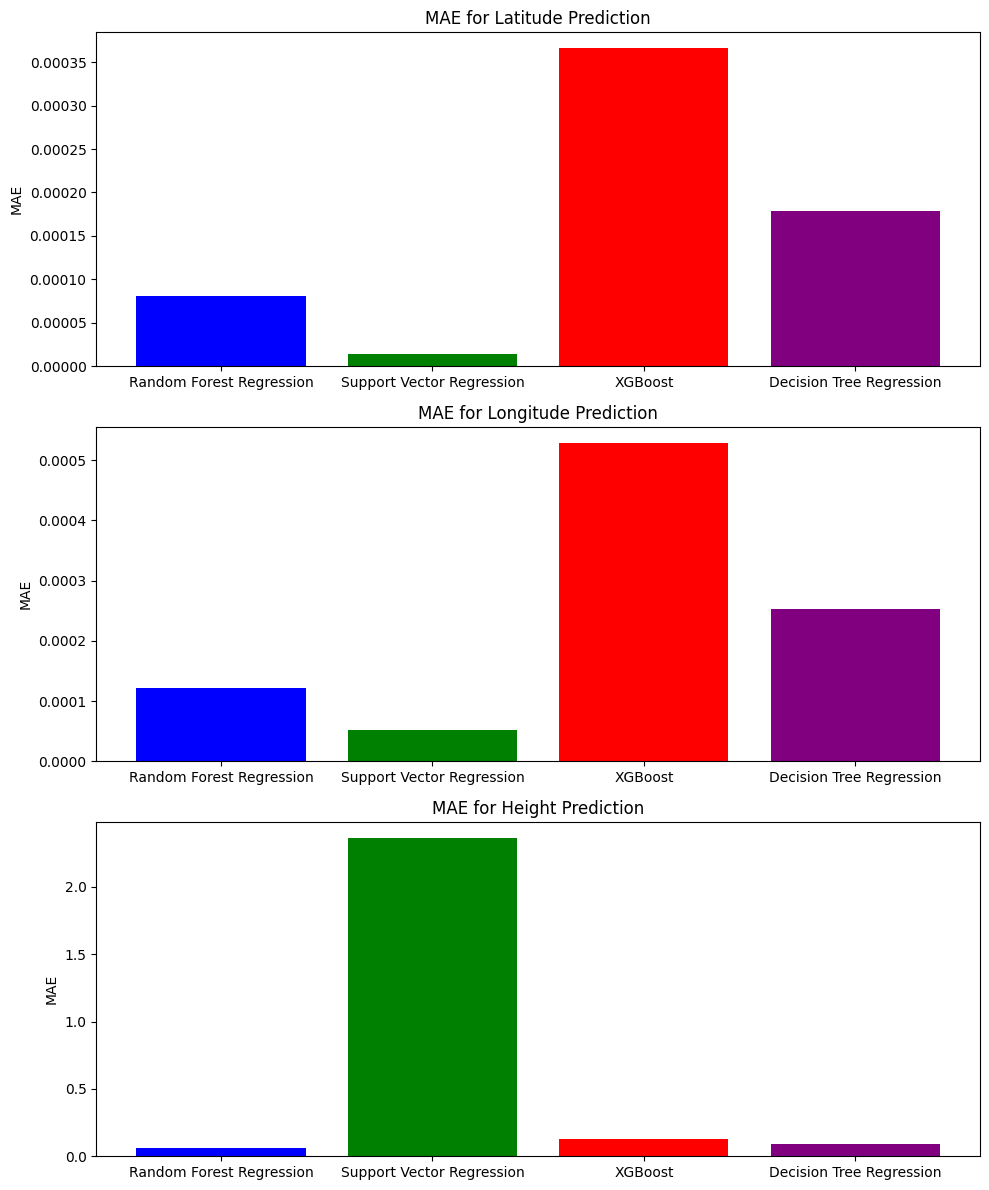

In [ ]:
import matplotlib.pyplot as plt

# Algorithm names
algorithms = ['Random Forest Regression', 'Support Vector Regression', 'XGBoost', 'Decision Tree Regression']

# MAE values for latitude prediction
latitude_mae = [0.000081, 0.000014, 0.000366, 0.000179]

# MAE values for longitude prediction
longitude_mae = [0.000122, 0.000052, 0.000528, 0.000253]

# MAE values for height prediction
height_mae = [0.063725, 2.361806, 0.129267, 0.090862]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Latitude plot
axs[0].bar(algorithms, latitude_mae, color=['blue', 'green', 'red', 'purple'])
axs[0].set_title('MAE for Latitude Prediction')
axs[0].set_ylabel('MAE')

# Longitude plot
axs[1].bar(algorithms, longitude_mae, color=['blue', 'green', 'red', 'purple'])
axs[1].set_title('MAE for Longitude Prediction')
axs[1].set_ylabel('MAE')

# Height plot
axs[2].bar(algorithms, height_mae, color=['blue', 'green', 'red', 'purple'])
axs[2].set_title('MAE for Height Prediction')
axs[2].set_ylabel('MAE')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Gaussian Process Regression (GPR) Solution

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# and you have features X (input) and target y (output)
Xgpr = df_wls_output[["millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"]]
ygpr_lat = df_sample_trail_gt["latDeg"]
ygpr_lng = df_sample_trail_gt["lngDeg"]
ygpr_height = df_sample_trail_gt["heightAboveWgs84EllipsoidM"]
# Initialize a list to store the results for each epoch
gpr_results = []

# Iterate over unique epoch times
for epoch_time in tqdm(df_wls_output["millisSinceGpsEpoch"].unique(), desc="Training GPR for each epoch"):
    # Extract relevant data for the current epoch
    df_sample_epoch = df_wls_output[df_wls_output["millisSinceGpsEpoch"] == epoch_time]

    # Split the data into training and testing sets
    Xgpr_train, Xgpr_test, ygpr_lat_train, ygpr_lat_test, ygpr_lng_train, ygpr_lng_test, ygpr_height_train, ygpr_height_test = train_test_split(
        Xgpr, ygpr_lat, ygpr_lng, ygpr_height, test_size=0.2, random_state=42
    )

    # Standardize the features
    scaler_Xgpr = StandardScaler()
    Xgpr_train_scaled = scaler_Xgpr.fit_transform(Xgpr_train)
    Xgpr_test_scaled = scaler_Xgpr.transform(Xgpr_test)

    # Standardize the target variables
    scaler_ygpr_lat = StandardScaler()
    ygpr_lat_train_scaled = scaler_ygpr_lat.fit_transform(ygpr_lat_train.values.reshape(-1, 1))
    ygpr_lat_test_scaled = scaler_ygpr_lat.transform(ygpr_lat_test.values.reshape(-1, 1))

    scaler_ygpr_lng = StandardScaler()
    ygpr_lng_train_scaled = scaler_ygpr_lng.fit_transform(ygpr_lng_train.values.reshape(-1, 1))
    ygpr_lng_test_scaled = scaler_ygpr_lng.transform(ygpr_lng_test.values.reshape(-1, 1))

    scaler_ygpr_height = StandardScaler()
    ygpr_height_train_scaled = scaler_ygpr_height.fit_transform(ygpr_height_train.values.reshape(-1, 1))
    ygpr_height_test_scaled = scaler_ygpr_height.transform(ygpr_height_test.values.reshape(-1, 1))

    # Define the GPR models with appropriate kernels
    kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
    gpr_lat = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gpr_lng = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gpr_height = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

    # Train the GPR models
    gpr_lat.fit(Xgpr_train_scaled, ygpr_lat_train_scaled.ravel())
    gpr_lng.fit(Xgpr_train_scaled, ygpr_lng_train_scaled.ravel())
    gpr_height.fit(Xgpr_train_scaled, ygpr_height_train_scaled.ravel())

    # Predictions
    ygpr_lat_pred_scaled, _ = gpr_lat.predict(Xgpr_test_scaled, return_std=True)
    ygpr_lng_pred_scaled, _ = gpr_lng.predict(Xgpr_test_scaled, return_std=True)
    ygpr_height_pred_scaled, _ = gpr_height.predict(Xgpr_test_scaled, return_std=True)

    # Inverse transform to get original scale
    ygpr_lat_pred = scaler_ygpr_lat.inverse_transform(ygpr_lat_pred_scaled.reshape(-1, 1))
    ygpr_lng_pred = scaler_ygpr_lng.inverse_transform(ygpr_lng_pred_scaled.reshape(-1, 1))
    ygpr_height_pred = scaler_ygpr_height.inverse_transform(ygpr_height_pred_scaled.reshape(-1, 1))

    # Calculate mean absolute error
    maegpr_lat = mean_absolute_error(ygpr_lat_test, ygpr_lat_pred)
    maegpr_lng = mean_absolute_error(ygpr_lng_test, ygpr_lng_pred)
    maegpr_height = mean_absolute_error(ygpr_height_test, ygpr_height_pred)

    print(f"Mean Absolute Error (Latitude): {maegpr_lat}")
    print(f"Mean Absolute Error (Longitude): {maegpr_lng}")
    print(f"Mean Absolute Error (Height): {maegpr_height}")

    # Append results to the list
    gpr_results.append({
        "millisSinceGpsEpoch": epoch_time,
        "maegpr_lat": maegpr_lat,
        "maegpr_lng": maegpr_lng,
        "maegpr_height": maegpr_height,
        # Add any other metrics you want to track for each epoch
    })

# Create a DataFrame from the list of results
df_gpr_results = pd.DataFrame(gpr_results)

# Display or save the results DataFrame
print(df_gpr_results)
df_gpr_results.to_csv("gpr_results.csv", index=False)

Training GPR for each epoch:   0%|          | 0/1739 [00:00<?, ?it/s]

ValueError: Found input variables with inconsistent numbers of samples: [1739, 1740, 1740, 1740]

## Evaluation

In [ ]:
def calc_haversine(lat1, lon1, lat2, lon2):
  """Calculates the great circle distance between two points
  on the earth. Inputs are array-like and specified in decimal degrees.
  """
  RADIUS = 6_367_000
  lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = np.sin(dlat/2)**2 + \
      np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  dist = 2 * RADIUS * np.arcsin(a**0.5)
  return dist

### Evaluate in one epoch

In [ ]:
deg_gt = df_sample_epoch_gt[["latDeg","lngDeg"]].to_numpy().transpose()
deg_baseline = df_sample_epoch_baseline[["latDeg","lngDeg"]].to_numpy().transpose()
print("Weighted Least Square (baseline) haversine distance (M):", calc_haversine(*deg_gt, *deg_baseline))
print("Weighted Least Square haversine distance (M):", calc_haversine(*deg_gt, *ecef2lla(*x[:3])[:2]))

Weighted Least Square (baseline) haversine distance (M): [2.74590055]
Weighted Least Square haversine distance (M): [[32.98570788]]


### Evaluate in whole training

In [ ]:
def simple_pipeline(df_trails):
  """ simple pipeline to estimate the GNSS receiver location by least square
  Args:
    df_trails: the df read from derived file

  Returns:
    result df with estimated degrees and heights
  """
  df_trails["correctedPrM"] = df_trails["rawPrM"] + df_trails["satClkBiasM"] - df_trails["isrbM"] - df_trails["ionoDelayM"] - df_trails["tropoDelayM"]

  results = []
  x = [0, 0, 0, 0]
  df_epochs = df_trails.groupby(["collectionName", "phoneName", "millisSinceGpsEpoch"])
  for indices, df_epoch in tqdm(df_epochs, desc="Estimate location by LS for epoch"):
    sat_pos = df_epoch[["xSatPosM","ySatPosM","zSatPosM"]].to_numpy()
    pseudoranges = np.squeeze(df_epoch[["correctedPrM"]].to_numpy())
    pseudoranges_sigma = np.squeeze(df_epoch[["rawPrUncM"]].to_numpy())
    x, _ = calc_pos_fix(sat_pos, pseudoranges, 1/pseudoranges_sigma, x)
    # x, _ = calc_pos_fix(sat_pos, pseudoranges, 1, x)
    values = np.squeeze(ecef2lla(*x[:3]))
    results.append([*indices, *values])
  return pd.DataFrame(results,columns=["collectionName", "phoneName", "millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"])

In [ ]:
from pathlib import Path
# from tqdm import tqdm
from tqdm.notebook import tqdm

# datapath = Path("./data")
#ground_truths = (datapath / "train").rglob("ground_truth.csv")
#drived_files = (datapath / "train").rglob("*_derived.csv")
#df_sample_trails_baseline = pd.read_csv('baseline_locations_train.csv')
#df_sample_trails_gt = pd.concat([pd.read_csv("ground_truth.csv") for filepath in tqdm(ground_truths, total=73, desc="Reading ground truth data")], ignore_index=True)
#df_sample_trails = pd.concat([pd.read_csv("Pixel4_derived.csv") for filepath in tqdm(drived_files, total=73, desc="Reading drived data")], ignore_index=True)
#df_sample_trails_baseline.to_csv('df_sample_trails_baseline.csv', sep=',', index=False, encoding='utf-8')
#df_sample_trails_gt.to_csv('df_sample_trails_gt.csv', sep=',', index=False, encoding='utf-8')
#df_sample_trails.to_csv('df_sample_trails.csv', sep=',', index=False, encoding='utf-8')

df_sample_trails_baseline = pd.read_csv('/content/gdrive/MyDrive/DRL/GNSS/df_sample_trails_baseline.csv')
df_sample_trails_gt = pd.read_csv("/content/gdrive/MyDrive/DRL/GNSS/df_sample_trails_gt.csv")
df_sample_trails = pd.read_csv("/content/gdrive/MyDrive/DRL/GNSS/df_sample_trails.csv")


In [ ]:
df_sample_trails_gt["receivedSvTimeInGpsNanos"] = df_sample_trails_gt.millisSinceGpsEpoch*int(1e6)
df_sample_trails_raw = df_sample_trails.drop("millisSinceGpsEpoch", axis=1)

df_merge = pd.merge_asof(df_sample_trails_raw.sort_values('receivedSvTimeInGpsNanos'), df_sample_trails_gt.sort_values('receivedSvTimeInGpsNanos'),
                                           on="receivedSvTimeInGpsNanos", by=["collectionName", "phoneName"], direction='nearest',tolerance=int(1e9))
df_merge = df_merge.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

In [ ]:
df_sample_trails_estimate = simple_pipeline(df_merge)

Estimate location by LS for epoch:   0%|          | 0/1739 [00:00<?, ?it/s]

In [ ]:
difference_lat = df_sample_trails_estimate.latDeg - df_sample_trails_baseline.latDeg.iloc[:1739]
difference_lng = df_sample_trails_estimate.lngDeg - df_sample_trails_baseline.lngDeg.iloc[:1739]
difference_H = df_sample_trails_estimate.heightAboveWgs84EllipsoidM - df_sample_trails_baseline.heightAboveWgs84EllipsoidM.iloc[:1739]

In [ ]:
difference_lat, difference_lng, difference_H

(0       3.874466e-06
 1       3.117139e-07
 2       2.193565e-06
 3      -4.967392e-06
 4      -3.879516e-06
             ...     
 1734   -6.107725e-06
 1735    2.321876e-06
 1736   -5.464511e-06
 1737   -6.171614e-06
 1738    2.976359e-06
 Name: latDeg, Length: 1739, dtype: float64,
 0       0.000333
 1       0.000333
 2       0.000331
 3       0.000335
 4       0.000330
           ...   
 1734    0.000343
 1735    0.000336
 1736    0.000345
 1737    0.000341
 1738    0.000333
 Name: lngDeg, Length: 1739, dtype: float64,
 0      -1.190750
 1      -0.568939
 2      -0.916072
 3       1.183702
 4       1.005652
           ...   
 1734    5.660107
 1735    3.367600
 1736    5.153159
 1737    5.429179
 1738    3.743298
 Name: heightAboveWgs84EllipsoidM, Length: 1739, dtype: float64)

In [ ]:
df_sample_trails_merged_baseline = pd.merge_asof(df_sample_trails_gt.sort_values('millisSinceGpsEpoch'),
                                                 df_sample_trails_baseline.sort_values('millisSinceGpsEpoch'),
                                                 on="millisSinceGpsEpoch", by=["collectionName", "phoneName"],
                                                 direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
df_sample_trails_merged_baseline = df_sample_trails_merged_baseline.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

df_sample_trails_merged_SL = pd.merge_asof(df_sample_trails_gt.sort_values('millisSinceGpsEpoch'),
                                           df_sample_trails_estimate.sort_values('millisSinceGpsEpoch'),
                                           on="millisSinceGpsEpoch", by=["collectionName", "phoneName"],
                                           direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
df_sample_trails_merged_SL = df_sample_trails_merged_SL.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

compared_cols = ["latDeg_truth","lngDeg_truth","latDeg_pred","lngDeg_pred"]
print("Weighted Least Square (baseline) haversine distance (M):", calc_haversine(*df_sample_trails_merged_baseline[compared_cols].to_numpy().transpose()).mean())
print("Weighted Least Square haversine distance (M):", calc_haversine(*df_sample_trails_merged_SL[compared_cols].to_numpy().transpose()).mean())

Weighted Least Square (baseline) haversine distance (M): 1.4564586662027648
Weighted Least Square haversine distance (M): 28.950978039949685
